# mlrose_hiive Generator and Runner Usage Examples - Andrew Rollings

## Overview

These examples will not solve assignment 2 for you, but they will give you
some idea on how to use the problem generator and runner classes.

Hopefully this will result in slightly fewer
"How do I &lt;insert basic usage here&gt;?" questions every semester...

### Import Libraries

In [540]:
from IPython.core.display import display, HTML # for some notebook formatting.

import mlrose_hiive
import numpy as np
import logging
import networkx as nx
import matplotlib.pyplot as plt
import string


from ast import literal_eval
import chess

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from mlrose_hiive import QueensGenerator, MaxKColorGenerator, TSPGenerator
from mlrose_hiive import SARunner, GARunner, NNGSRunner

# switch off the chatter
logging.basicConfig(level=logging.WARNING)

### Example 1: Generating and Running 8-Queens using the SA algorithm

In [541]:
# Generate a new 8-Queen problem using a fixed seed.
problem = QueensGenerator().generate(seed=123456, size=8)

The initial state is as follows:

[2 3 3 2 7 0 1 1]


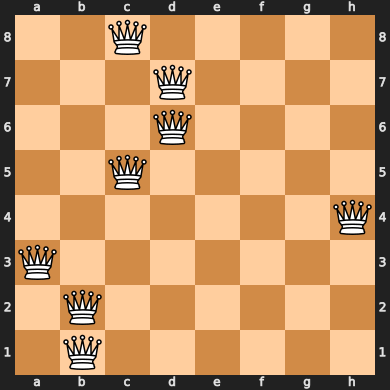

In [542]:
state = problem.get_state()
print(state)
board_layout = '/'.join([''.join(([str(s)] if s > 0 else []) + ['Q'] + ([str((7-s))] if s < 7 else [])) for s in state])
board = chess.Board(board_layout)
board

In [543]:
# create a runner class and solve the problem
sa = SARunner(problem=problem,
              experiment_name='queens8_sa',
              output_directory=None, # note: specify an output directory to have results saved to disk
              seed=123456,
              iteration_list=2 ** np.arange(11),
              max_attempts=500,
              temperature_list=[0.1, 0.5, 0.75, 1.0, 2.0, 5.0],
              decay_list=[mlrose_hiive.GeomDecay])

# the two data frames will contain the results
df_run_stats, df_run_curves = sa.run()

The preceding code will run the `SA` algorithm six times for at most 1024 iterations.
Each run is initialized with the temperature specified in the `temperature_list`
using the temperature values specified.

If the fitness remains static for `max_attempts` iterations, it will terminate that run.

Note that the initial state parameters here are just toy values picked specifically
for this example. You will have to choose your own range of values for your
assignment. I strongly recommend you don't just copy these, or you will find
that the grading is unlikely to go the way you would like.

The output in the `df_run_stats` dataframe contains snapshots of the state of the algorithm at the iterations
specified in the `iteration_list` passed into the runner class.

The first 12 rows (corresponding to the first run of this algorithm) are as follows:

In [544]:
HTML(df_run_stats[['Iteration', 'Fitness', 'FEvals', 'Time', 'State']][0:12].to_html())

,Iteration,Fitness,FEvals,Time,State
0,0,11.0,0,0.001129,"[1, 2, 2, 1, 0, 3, 7, 3]"
1,1,9.0,2,0.005120,"[1, 2, 2, 0, 0, 3, 7, 3]"
2,2,8.0,4,0.008985,"[1, 2, 2, 0, 0, 3, 7, 5]"
3,4,8.0,7,0.013289,"[1, 2, 2, 5, 0, 3, 7, 5]"
4,8,5.0,13,0.018131,"[1, 2, 7, 5, 0, 3, 5, 5]"
5,16,4.0,24,0.023681,"[1, 2, 7, 5, 3, 0, 5, 5]"
6,32,4.0,47,0.033048,"[1, 5, 7, 5, 0, 0, 3, 4]"
7,64,1.0,86,0.048564,"[1, 5, 2, 6, 3, 0, 7, 4]"
8,128,1.0,155,0.076681,"[1, 5, 2, 6, 3, 0, 4, 7]"
9,256,1.0,295,0.137069,"[1, 7, 2, 6, 3, 5, 0, 4]"


The state information is excluded from the previous output.

A sample of this (based on the state of the `GeomDecay` object) is below:

In [545]:
state_sample = df_run_stats[['schedule_current_value', 'schedule_init_temp', 'schedule_min_temp']][:1]
HTML(state_sample.to_html())

,schedule_current_value,schedule_init_temp,schedule_min_temp
0,0.099999,0.1,0.001


So, to pick out the most performant run from the dataframe, you need to find the row with the best fitness.
As 8-Queens is a minimization problem, you'd pick the row with the minimum fitness.

However, I'm going to look in the `run_curves` (which stores minimal basic information every iteration) to
find out which input state achieved the best fitness in the fewest fitness evaluations.

In [546]:
best_fitness = df_run_curves['Fitness'].min()
best_runs = df_run_curves[df_run_curves['Fitness'] == best_fitness]

HTML(best_runs.to_html())

,Iteration,Time,Fitness,FEvals,Temperature,max_iters
414,414,0.220634,0.0,461.0,0.1,1024
829,414,0.220634,0.0,461.0,0.5,1024
2416,561,0.084773,0.0,639.0,1.0,1024
2739,322,0.170785,0.0,427.0,2.0,1024
3164,424,0.019658,0.0,583.0,5.0,1024


This gives us five candidates for the best run. We are going to pick the one with
that reached the best fitness value in the fewest number of evaluations.

(We could also have chosen to use `Iterations` as our criteria.)

In [547]:
minimum_evaluations = best_runs['FEvals'].min()

best_curve_run = best_runs[best_runs['FEvals'] == minimum_evaluations]

The best run using these criteria is as follows:

In [548]:
HTML(best_curve_run.to_html())

,Iteration,Time,Fitness,FEvals,Temperature,max_iters
2739,322,0.170785,0.0,427.0,2.0,1024


Which has the following identifying state information:

In [549]:
best_init_temperature = best_curve_run['Temperature'].iloc()[0].init_temp

print(f'Best initial temperature: {best_init_temperature}')


Best initial temperature: 2.0


To map this back to the `run_stats` we look at the configuration data included in
the curve data. The curve data includes at least the minimum identifying information
to determine which run each row came from.

In this case, the value we are looking for is the `Temperature`, which is the initial temperature
used to initialize the `GeomDecay` object.

So, in this case, we are looking for all rows in `df_run_stats` where the temperature is equal to 1.

In [550]:
run_stats_best_run = df_run_stats[df_run_stats['schedule_init_temp'] == best_init_temperature]
HTML(run_stats_best_run[['Iteration', 'Fitness', 'FEvals', 'Time', 'State']].to_html())

,Iteration,Fitness,FEvals,Time,State
48,0,11.0,0,0.000470,"[1, 2, 2, 1, 0, 3, 7, 3]"
49,1,9.0,2,0.005766,"[1, 2, 2, 0, 0, 3, 7, 3]"
50,2,8.0,4,0.011186,"[1, 2, 2, 0, 0, 3, 7, 5]"
51,4,8.0,7,0.017125,"[1, 2, 2, 5, 0, 3, 7, 5]"
52,8,7.0,14,0.023327,"[1, 2, 2, 5, 0, 3, 5, 5]"
53,16,6.0,27,0.031316,"[3, 2, 3, 5, 0, 1, 5, 5]"
54,32,4.0,57,0.043843,"[3, 5, 6, 5, 5, 0, 4, 7]"
55,64,5.0,114,0.063941,"[2, 0, 3, 6, 1, 2, 1, 7]"
56,128,3.0,205,0.093703,"[2, 0, 6, 3, 5, 0, 4, 3]"
57,256,2.0,358,0.147134,"[7, 1, 3, 6, 6, 4, 0, 5]"


And the best state associated with this is:

In [551]:
best_state = run_stats_best_run[['schedule_current_value', 'schedule_init_temp', 'schedule_min_temp']][:1]
HTML(best_state.to_html())

,schedule_current_value,schedule_init_temp,schedule_min_temp
48,1.999991,2.0,0.001


The final state is as follows:

[7, 1, 3, 0, 6, 4, 2, 5]


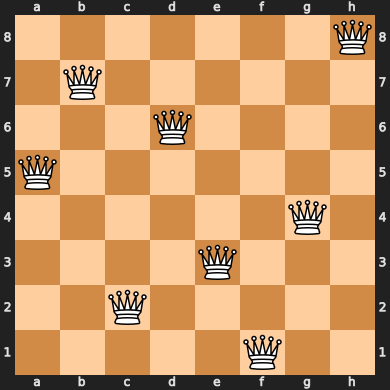

In [552]:
state = literal_eval(run_stats_best_run['State'].tail(1).values[0])
print(state)
board_layout = '/'.join([''.join(([str(s)] if s > 0 else []) + ['Q'] + ([str((7-s))] if s < 7 else [])) for s in state])
board = chess.Board(board_layout)
board

### Example 2: Generating and Running Max K Color using the GA algorithm

In [553]:
# Generate a new Max K problem using a fixed seed.
problem = MaxKColorGenerator().generate(seed=123456, number_of_nodes=10, max_connections_per_node=3, max_colors=3)

The input graph generated for the problem looks like this:

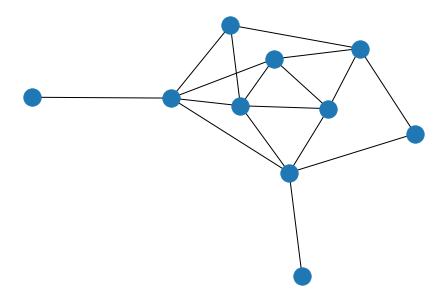

In [554]:
nx.draw(problem.source_graph,
        pos=nx.spring_layout(problem.source_graph, seed = 3))
plt.show()

In [555]:
# create a runner class and solve the problem
ga = GARunner(problem=problem,
              experiment_name='max_k_ga',
              output_directory=None, # note: specify an output directory to have results saved to disk
              seed=123456,
              iteration_list=2 ** np.arange(11),
              population_sizes=[10, 20, 50],
              mutation_rates=[0.1, 0.2, 0.5])

# the two data frames will contain the results
df_run_stats, df_run_curves = ga.run()

The preceding code will run the `GA` algorithm nine times for at most 1024 iterations per run.
Each run is a permutation from the list of `population_sizes` and `mutation_rates`.

Note that the initial state parameters here are just toy values picked specifically
for this example. You will have to choose your own range of values for your
assignment. I strongly recommend you don't just copy these, or you will find
that the grading is unlikely to go the way you would like.

Really. I mean it... A mutation rate of 0.5 is little better than a pure random search.

The output in the `df_run_stats` dataframe contains snapshots of the state of the algorithm at the iterations
specified in the `iteration_list` passed into the runner class.

The first row (corresponding to the first run of this algorithm) are as follows:

In [556]:
HTML(df_run_stats[['Iteration', 'Fitness', 'FEvals', 'Time', 'State']][0:1].to_html())

,Iteration,Fitness,FEvals,Time,State
0,0,3.0,10,0.000706,"[1, 2, 2, 1, 0, 0, 0, 0, 2, 2]"


The state information is excluded from the previous output.

A sample of this is below:

In [557]:
state_sample = df_run_stats[['Population Size', 'Mutation Rate']][:1]
HTML(state_sample.to_html())


,Population Size,Mutation Rate
0,10,0.1


So, to pick out the most performant run from the dataframe, you need to find the row with the best fitness.
As Max-K-Color is a minimization problem, you'd pick the row with the minimum fitness.

However, I'm going to look in the `run_curves` (which stores minimal basic information every iteration) to
find out which input state achieved the best fitness in the fewest fitness evaluations.

In [558]:
best_fitness = df_run_curves['Fitness'].min()
best_runs = df_run_curves[df_run_curves['Fitness'] == best_fitness]

HTML(best_runs.to_html())

,Iteration,Time,Fitness,FEvals,Population Size,Mutation Rate,max_iters
4,4,0.010124,0.0,57.0,10,0.1,1024
9,4,0.010124,0.0,57.0,10,0.2,1024
18,8,0.009299,0.0,101.0,10,0.5,1024
24,5,0.000571,0.0,127.0,20,0.1,1024
27,2,0.006554,0.0,64.0,20,0.2,1024
31,3,0.009144,0.0,85.0,20,0.5,1024
41,9,0.010003,0.0,511.0,50,0.1,1024
45,3,0.009144,0.0,205.0,50,0.2,1024
50,4,0.010124,0.0,256.0,50,0.5,1024


This gives us nine candidates for the best run. We are going to pick the one with
that reached the best fitness value in the fewest number of evaluations.

(We could also have chosen to use `Iterations` as our criteria.)

In [559]:
minimum_evaluations = best_runs['FEvals'].min()

best_curve_run = best_runs[best_runs['FEvals'] == minimum_evaluations]

The best runs using these criteria is as follows:

In [560]:
HTML(best_curve_run.to_html())

,Iteration,Time,Fitness,FEvals,Population Size,Mutation Rate,max_iters
4,4,0.010124,0.0,57.0,10,0.1,1024
9,4,0.010124,0.0,57.0,10,0.2,1024


We will arbitrarily pick the first row for this example,
which has the following identifying state information:

In [561]:
best_mr = best_curve_run['Mutation Rate'].iloc()[0]
best_pop_size = best_curve_run['Population Size'].iloc()[0]
print(f'Best Mutation Rate: {best_mr}, best Population Size: {best_pop_size}')


Best Mutation Rate: 0.1, best Population Size: 10


To map this back to the `run_stats` we look at the configuration data included in
the curve data. The curve data includes at least the minimum identifying information
to determine which run each row came from.

In this case, the values we are looking for are the `Mutation Rate` and `Population Size`.

So, we are looking for all rows in `df_run_stats` where the mutation rate and population size are equal to our best values.

In [562]:
run_stats_best_run = df_run_stats[(df_run_stats['Mutation Rate'] == best_mr) & (df_run_stats['Population Size'] == best_pop_size)]
HTML(run_stats_best_run[['Iteration', 'Fitness', 'FEvals', 'Time']].to_html())

,Iteration,Fitness,FEvals,Time
0,0,3.0,10,0.000706
1,1,3.0,21,0.003727
2,2,2.0,33,0.006554
3,4,0.0,57,0.010124
4,8,0.0,57,0.010124
5,16,0.0,57,0.010124
6,32,0.0,57,0.010124
7,64,0.0,57,0.010124
8,128,0.0,57,0.010124
9,256,0.0,57,0.010124


And the best state associated with this is:

In [563]:
best_state = run_stats_best_run[['State']][:1]
HTML(best_state.to_html())

,State
0,"[1, 2, 2, 1, 0, 0, 0, 0, 2, 2]"


For the following node ordering:

In [564]:
print([n for n in problem.source_graph.nodes])

[0, 2, 8, 1, 3, 4, 6, 7, 9, 5]


Reordering the state by ascending node number gives the following:

In [565]:
color_indexes = literal_eval(run_stats_best_run['State'].tail(1).values[0])
ordered_state = [color_indexes[n] for n in problem.source_graph.nodes]
print(ordered_state)

[0, 2, 2, 1, 0, 0, 0, 1, 1, 2]


Which results in a graph looking like this:

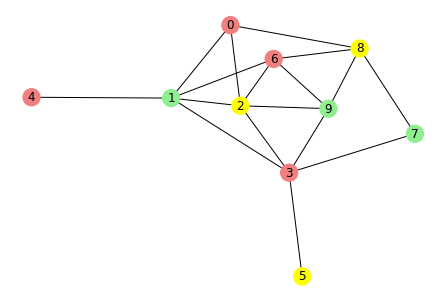

In [566]:
colors = ['lightcoral', 'lightgreen', 'yellow']
node_color_map = [colors[s] for s in ordered_state]

nx.draw(problem.source_graph,
        pos=nx.spring_layout(problem.source_graph, seed = 3),
        with_labels=True,
        node_color=node_color_map)
plt.show()

### Example 3: Generating and Running TSP using the GA algorithm

In [567]:
# Generate a new TSP problem using a fixed seed.
problem = TSPGenerator().generate(seed=123456, number_of_cities=8)

The input graph generated for the problem looks like this (not to scale, obviously).

The edge labels show the distance between nodes, and the salesman starts at the green city:

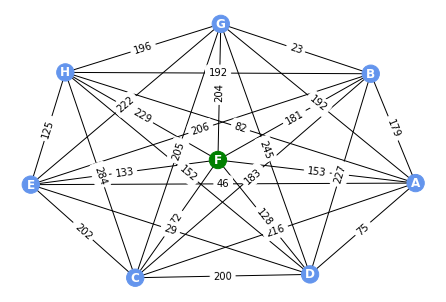

In [568]:
node_color_map = ['green' if i == 5 else 'cornflowerblue' for i in range(len(problem.source_graph.nodes))]
edge_labels = nx.get_edge_attributes(problem.source_graph,'length')
node_labels = {k:str(v) for k, v in enumerate(string.ascii_uppercase) if k < len(problem.source_graph.nodes)}
pos = nx.spring_layout(problem.source_graph, seed = 4)
nx.draw(problem.source_graph, pos=pos, node_color=node_color_map)
nx.draw_networkx_labels(problem.source_graph, pos=pos, labels=node_labels, font_color='white', font_weight='bold')
nx.draw_networkx_edge_labels(problem.source_graph, pos=pos, edge_labels=edge_labels)
plt.show()

In [569]:
# create a runner class and solve the problem
ga = GARunner(problem=problem,
              experiment_name='tsp_ga',
              output_directory=None, # note: specify an output directory to have results saved to disk
              seed=123456,
              iteration_list=2 ** np.arange(11),
              population_sizes=[10, 20],
              mutation_rates=[0.1, 0.25, 0.5])

# the two data frames will contain the results
df_run_stats, df_run_curves = ga.run()

The preceding code will run the `GA` algorithm nine times for at most 1024 iterations per run.
Each run is a permutation from the list of `population_sizes` and `mutation_rates`.

Note that the initial state parameters here are just toy values picked specifically
for this example. You will have to choose your own range of values for your
assignment. I strongly recommend you don't just copy these, or you will find
that the grading is unlikely to go the way you would like.

Really. I mean it... A mutation rate of 0.5 is little better than a pure random search.

The output in the `df_run_stats` dataframe contains snapshots of the state of the algorithm at the iterations
specified in the `iteration_list` passed into the runner class.

The first row (corresponding to the first run of this algorithm) are as follows:

In [570]:
HTML(df_run_stats[['Iteration', 'Fitness', 'FEvals', 'Time', 'State']][0:1].to_html())

,Iteration,Fitness,FEvals,Time,State
0,0,1083.699088,10,0.000577,"[5, 4, 3, 0, 7, 6, 2, 1]"


The state information is excluded from the previous output.

A sample of this is below:

In [571]:
state_sample = df_run_stats[['Population Size', 'Mutation Rate']][:1]
HTML(state_sample.to_html())


,Population Size,Mutation Rate
0,10,0.1


So, to pick out the most performant run from the dataframe, you need to find the row with the best fitness.
As TSP is a minimization problem, you'd pick the row with the minimum fitness.

However, I'm going to look in the `run_curves` (which stores minimal basic information every iteration) to
find out which input state achieved the best fitness in the fewest fitness evaluations.

In [572]:
best_fitness = df_run_curves['Fitness'].min()
best_runs = df_run_curves[df_run_curves['Fitness'] == best_fitness]

HTML(best_runs[0:10].to_html())

,Iteration,Time,Fitness,FEvals,Population Size,Mutation Rate,max_iters
162,162,0.229747,758.466417,1797.0,10,0.1,1024
163,163,0.230973,758.466417,1808.0,10,0.1,1024
164,164,0.232111,758.466417,1819.0,10,0.1,1024
165,165,0.233192,758.466417,1830.0,10,0.1,1024
166,166,0.234267,758.466417,1841.0,10,0.1,1024
167,167,0.235351,758.466417,1852.0,10,0.1,1024
168,168,0.236636,758.466417,1863.0,10,0.1,1024
169,169,0.238277,758.466417,1874.0,10,0.1,1024
170,170,0.239535,758.466417,1885.0,10,0.1,1024
171,171,0.240603,758.466417,1896.0,10,0.1,1024


This gives us nine candidates for the best run. We are going to pick the one with
that reached the best fitness value in the fewest number of evaluations.

(We could also have chosen to use `Iterations` as our criteria.)

In [573]:
minimum_evaluations = best_runs['FEvals'].min()

best_curve_run = best_runs[best_runs['FEvals'] == minimum_evaluations]

The best runs using these criteria is as follows:

In [574]:
HTML(best_curve_run.to_html())

,Iteration,Time,Fitness,FEvals,Population Size,Mutation Rate,max_iters
2861,12,0.026642,758.466417,276.0,20,0.5,1024


This has the following identifying state information:

In [575]:
best_mr = best_curve_run['Mutation Rate'].iloc()[0]
best_pop_size = best_curve_run['Population Size'].iloc()[0]
print(f'Best Mutation Rate: {best_mr}, best Population Size: {best_pop_size}')


Best Mutation Rate: 0.5, best Population Size: 20


To map this back to the `run_stats` we look at the configuration data included in
the curve data. The curve data includes at least the minimum identifying information
to determine which run each row came from.

In this case, the values we are looking for are the `Mutation Rate` and `Population Size`.

So, we are looking for all rows in `df_run_stats` where the mutation rate and population size are equal to our best values.

In [576]:
run_stats_best_run = df_run_stats[(df_run_stats['Mutation Rate'] == best_mr) & (df_run_stats['Population Size'] == best_pop_size)]
HTML(run_stats_best_run[['Iteration', 'Fitness', 'FEvals', 'Time']].to_html())

,Iteration,Fitness,FEvals,Time
60,0,1083.699088,20,0.000793
61,1,911.519560,42,0.008156
62,2,833.174301,64,0.015491
63,4,833.174301,106,0.025400
64,8,792.120399,191,0.040042
65,16,758.466417,360,0.062835
66,32,758.466417,696,0.103934
67,64,758.466417,1368,0.181838
68,128,758.466417,2712,0.341615
69,256,758.466417,5400,0.638305


And the best state associated with this is:

In [577]:
best_state = run_stats_best_run[['State']][:1]
HTML(best_state.to_html())

,State
60,"[5, 4, 3, 0, 7, 6, 2, 1]"


Which results in a graph looking like this:

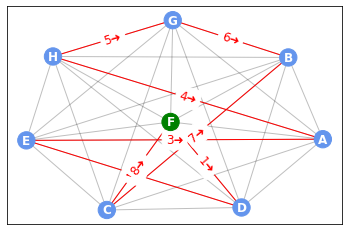

In [578]:
ordered_state = literal_eval(run_stats_best_run['State'].tail(1).values[0])
edge_labels = {(ordered_state[i], ordered_state[(i+1) % len(ordered_state)]):f'{str(i+1)}➜' for i in range(len(ordered_state))}

node_labels = {k:str(v) for k, v in enumerate(string.ascii_uppercase) if k < len(problem.source_graph.nodes)}
node_color_map = ['green' if i == 5 else 'cornflowerblue' for i in range(len(problem.source_graph.nodes))]
pos = nx.spring_layout(problem.source_graph, seed = 4)
nx.draw_networkx_nodes(problem.source_graph, pos=pos, node_color=node_color_map)
nx.draw_networkx_edges(problem.source_graph, pos=pos, alpha=0.25)
nx.draw_networkx_edges(problem.source_graph, pos=pos, edgelist=edge_labels.keys(), edge_color='red')
nx.draw_networkx_edge_labels(problem.source_graph, pos=pos, edge_labels=edge_labels, font_color='red', font_size=12, font_weight='normal')
nx.draw_networkx_labels(problem.source_graph, pos=pos, labels=node_labels, font_color='white', font_weight='bold')
plt.show()

And, to verify that the route is correct (or at least, the shortest one found):

In [579]:
all_edge_lengths = {(x, y):d for x, y, d in problem.distances}
all_edge_lengths.update({(y, x):d for x, y, d in problem.distances})

route_length = sum([all_edge_lengths[k] for k in edge_labels.keys()])
print(f'route_length: ({round(route_length, 6)}) equal to best_fitness: ({round(best_fitness, 6)})')

route_length: (758.466417) equal to best_fitness: (758.466417)


### Example 4: Using the NNGSRunner with the RHC algorithm

In [580]:
# Load and Split data into training and test sets
data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(
    data.data, data.target, test_size = 0.3, random_state = 123456
)

# Normalize feature data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# One hot encode target values
one_hot = OneHotEncoder()
y_train_hot = one_hot.fit_transform(y_train.reshape(-1, 1)).todense()
y_test_hot = one_hot.transform(y_test.reshape(-1, 1)).todense()

grid_search_parameters = {
    'max_iters': [1000],                          # nn params
    'learning_rate': [1e-2],                       # nn params
    'activation': [mlrose_hiive.relu],            # nn params
    'restarts': [1],                             # rhc params
}

nnr = NNGSRunner(
    x_train=X_train_scaled,
    y_train=y_train_hot,
    x_test=X_test_scaled,
    y_test=y_test_hot,
    experiment_name='nn_test_rhc',
    algorithm=mlrose_hiive.algorithms.rhc.random_hill_climb,
    grid_search_parameters=grid_search_parameters,
    iteration_list=[1, 10, 50, 100, 250, 500, 1000],
    hidden_layer_sizes=[[2]],
    bias=True,
    early_stopping=True,
    clip_max=5,
    max_attempts=500,
    n_jobs=5,
    seed=123456,
    output_directory=None
)


run_stats_df, curves_df, cv_results_df, grid_search_cv = nnr.run()

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    2.9s remaining:    4.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    3.0s finished


The runner returns the `run_stats` and `curves` corresponding to *best* hyperparameter combination,
as well as the cross validation results and the underlying `GridSearchCV` object used in the run.

In [581]:
y_test_pred = grid_search_cv.predict(X_test_scaled)
y_test_accuracy = accuracy_score(y_test_hot, y_test_pred)
print(y_test_accuracy)


0.3333333333333333


In [582]:
y_train_pred = grid_search_cv.predict(X_train_scaled)
y_train_accuracy = accuracy_score(y_train_hot, y_train_pred)
print(y_train_accuracy)

0.3333333333333333


In [583]:
HTML(run_stats_df[['current_restart', 'Iteration', 'Fitness', 'FEvals', 'Time', 'learning_rate']][0:14].to_html())

,current_restart,Iteration,Fitness,FEvals,Time,learning_rate
0,0,0,1.306448,1,0.002497,0.01
1,0,1,1.290536,3,0.009354,0.01
2,0,10,1.246087,14,0.025565,0.01
3,0,50,1.115004,67,0.076785,0.01
4,0,100,1.044654,127,0.125543,0.01
5,0,250,0.877647,308,0.274282,0.01
6,0,500,0.739120,614,0.535828,0.01
7,0,1000,0.732424,1175,1.119993,0.01
8,1,0,1.306448,1175,1.128620,0.01
9,1,1,1.306448,1176,1.136495,0.01


In [584]:
HTML(curves_df[['current_restart', 'Iteration', 'Fitness', 'FEvals', 'Time', 'learning_rate']][0:20].to_html())

,current_restart,Iteration,Fitness,FEvals,Time,learning_rate
0,0,0,1.290536,1.0,0.002497,0.01
1,0,1,1.290536,3.0,0.009354,0.01
2,0,2,1.290536,4.0,0.015044,0.01
3,0,3,1.290536,5.0,0.016143,0.01
4,0,4,1.263664,7.0,0.018189,0.01
5,0,5,1.263664,8.0,0.019251,0.01
6,0,6,1.246087,10.0,0.021309,0.01
7,0,7,1.246087,11.0,0.022367,0.01
8,0,8,1.246087,12.0,0.023431,0.01
9,0,9,1.246087,13.0,0.024494,0.01


In [585]:
HTML(cv_results_df[['mean_test_score', 'rank_test_score', 'mean_train_score', 'param_activation', 'param_hidden_layer_sizes', 'param_learning_rate',
                    'param_max_iters', 'param_restarts']].to_html())

,mean_test_score,rank_test_score,mean_train_score,param_activation,param_hidden_layer_sizes,param_learning_rate,param_max_iters,param_restarts
0,0.333333,1,0.333333,relu,[2],0.01,1000,1
